# **Chapter 4 - Geocentric Models**

In [43]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
module_path = os.path.abspath(os.path.join("../.."))
parent_dir = os.path.dirname(os.getcwd())
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import arviz as az

import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from scipy.interpolate import griddata

In [3]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
plt.rcParams["figure.dpi"] = 240

#### **4.1 Simulation of field trip**

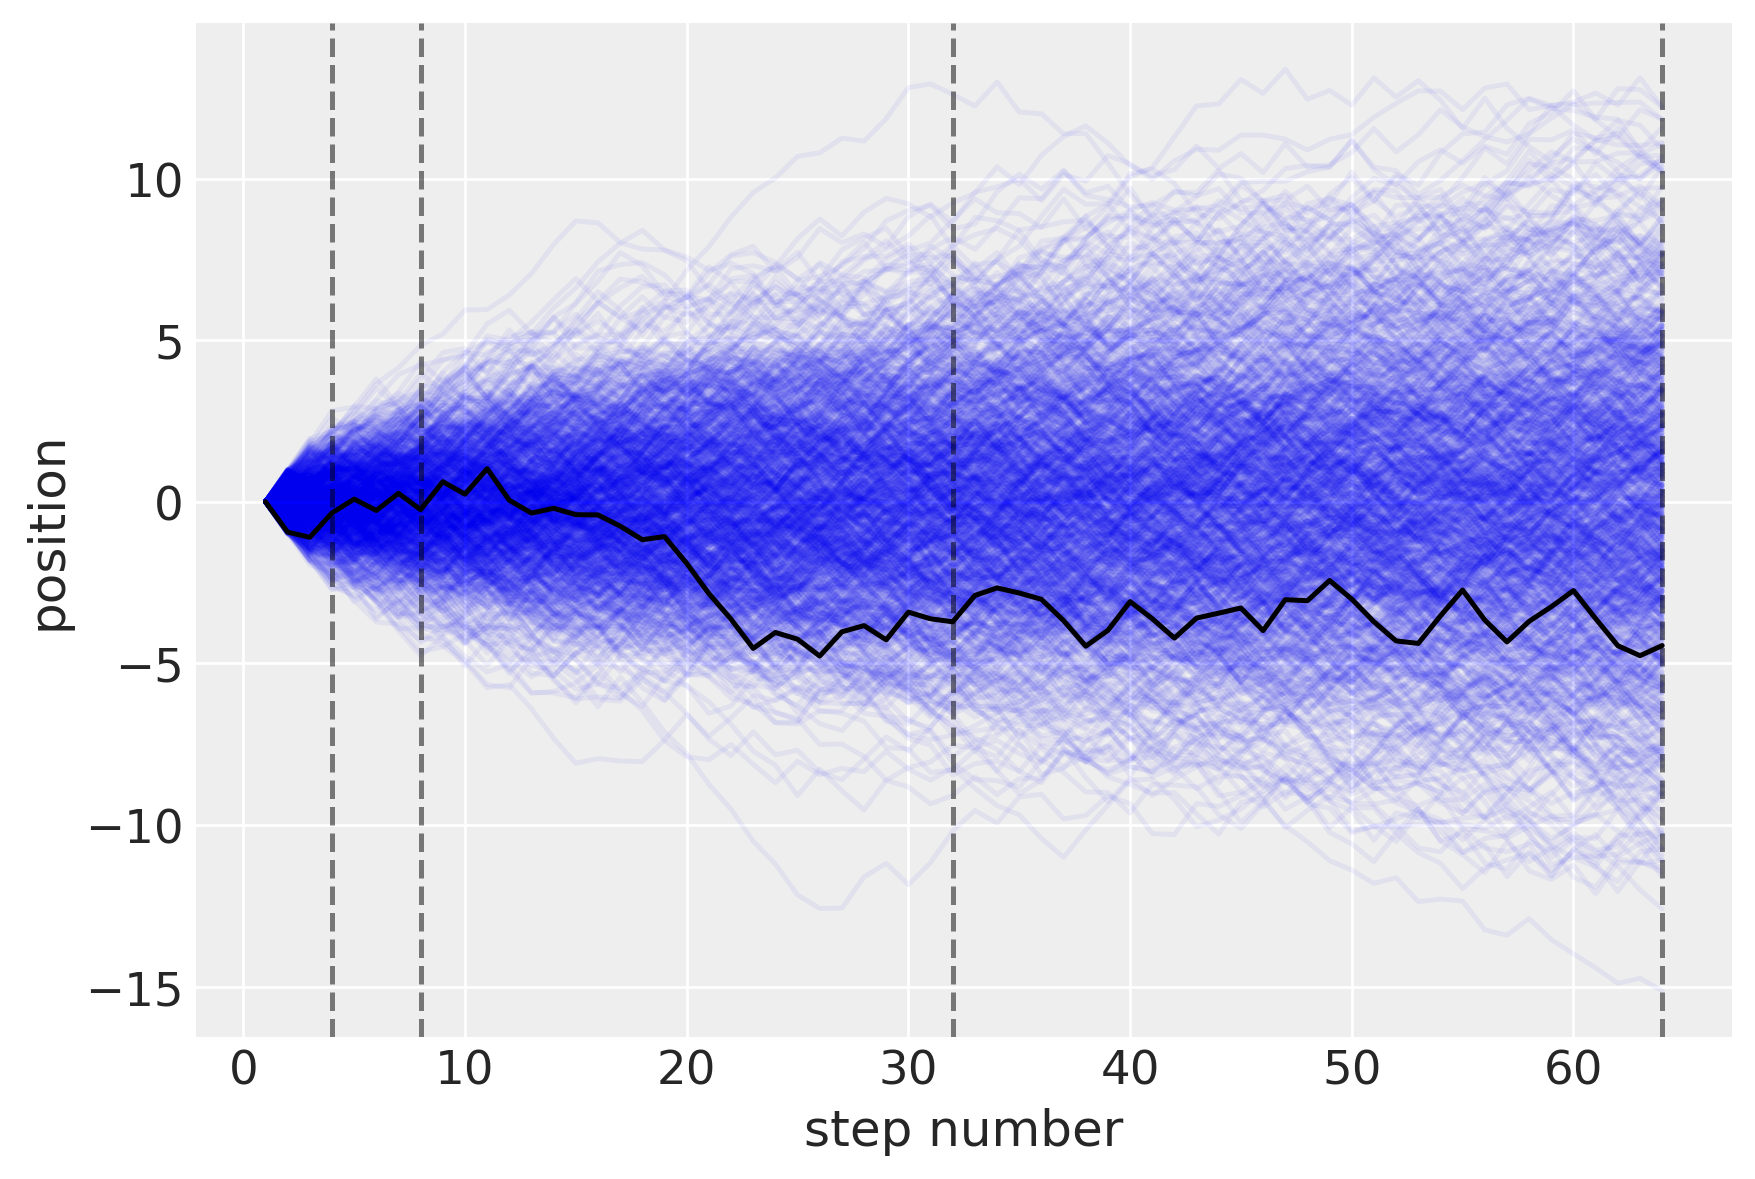

In [17]:
np.random.seed(42069)
steps = 64
repetitions = 1000
x = np.zeros([steps, repetitions])
for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(np.random.uniform(-1, 1, steps - 1))

plt.plot(range(1, steps+1), x[:, :], c="b", alpha=0.05)
plt.plot(range(1, steps+1), x[:, 0], c="k")
plt.axvline(4, linestyle="--", c="k", alpha=0.5)
plt.axvline(8, linestyle="--", c="k", alpha=0.5)
plt.axvline(steps//2, linestyle="--", c="k", alpha=0.5)
plt.axvline(steps, linestyle="--", c="k", alpha=0.5)
plt.xlabel("step number")
plt.ylabel("position")
plt.show()

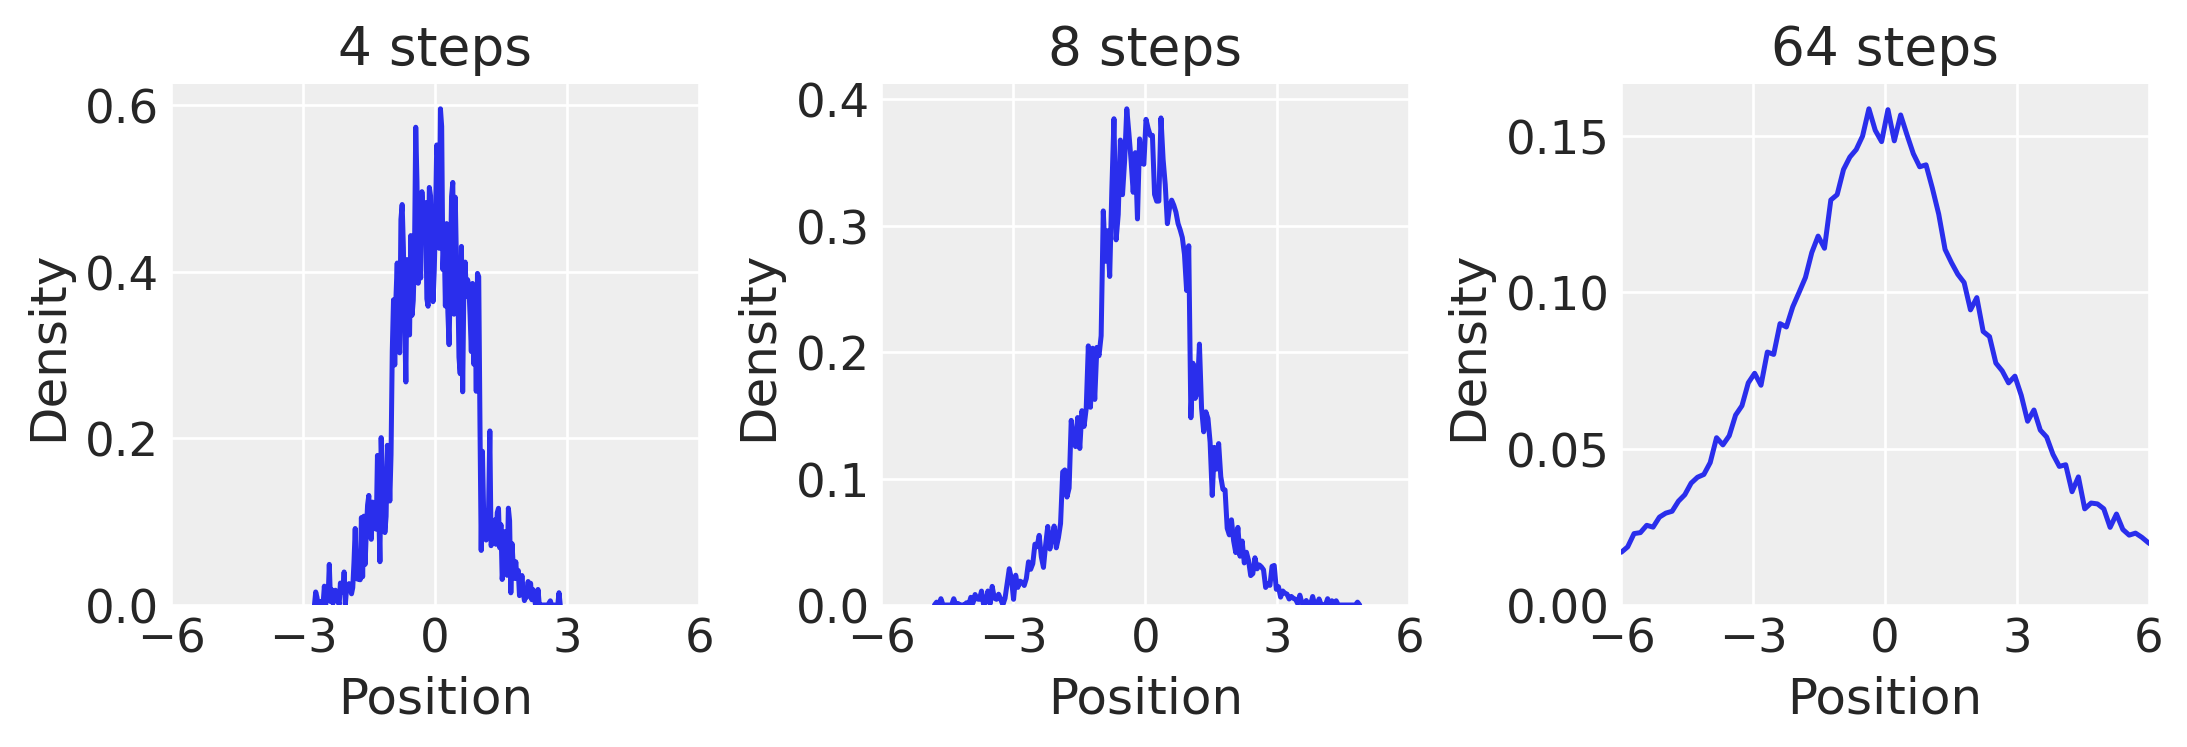

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, dpi = 240)
sns.distplot(x[1:4, :], kde_kws={"bw": 0.01}, ax=ax[0], hist=False)
sns.distplot(x[1:8, :], kde_kws={"bw": 0.01}, ax=ax[1], hist=False)
sns.distplot(x[1:, :], kde_kws={"bw": 0.01}, ax=ax[2], hist=False)

ax[0].set_title("4 steps")
ax[1].set_title("8 steps")
ax[2].set_title(f"{steps} steps")

for i in range(3):
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel("Position")
    ax[i].set_xlim(-6, 6)
    ax[i].set_xticks([-6, -3, 0, 3, 6])

#### **Code 4.1**

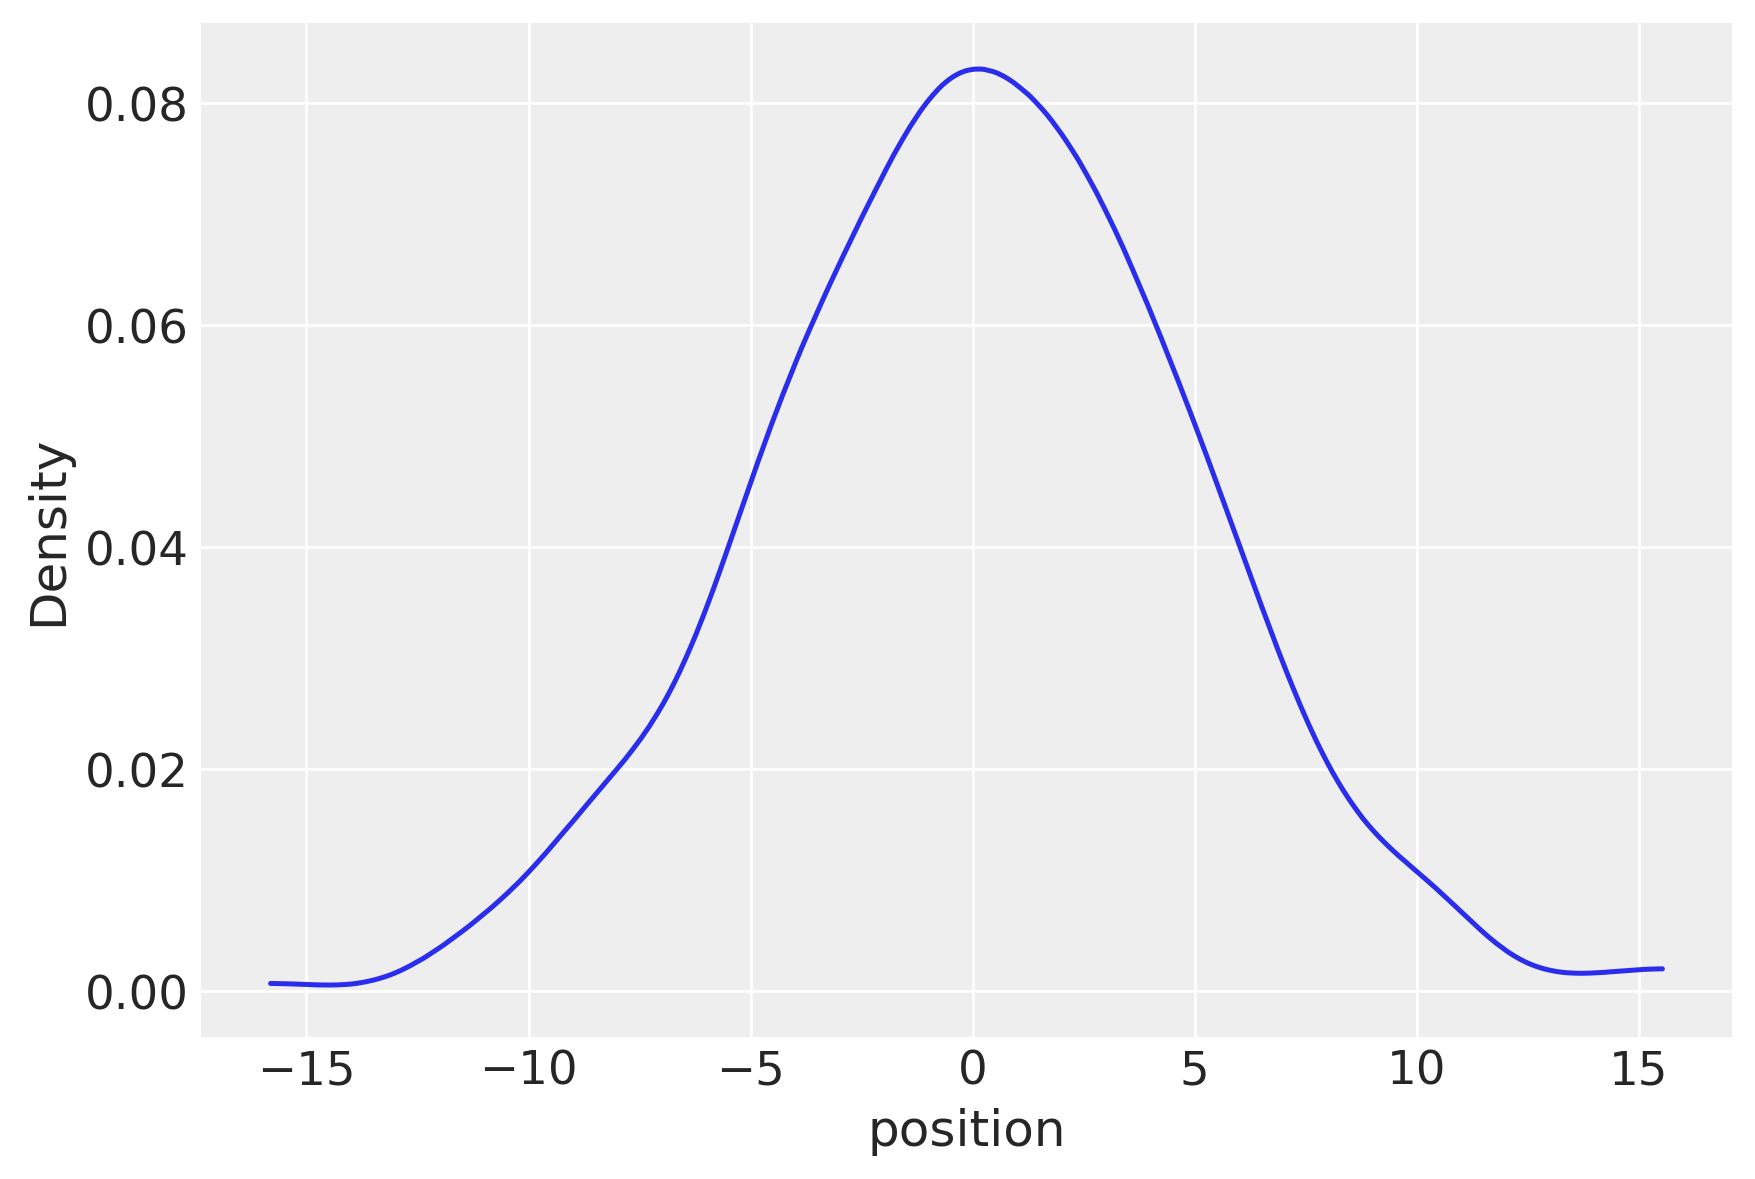

In [21]:
steps = 64
pos = np.random.uniform(-1, 1, size=(steps, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel("position")
plt.ylabel("Density");

#### **Code 4.2 and 4.3**

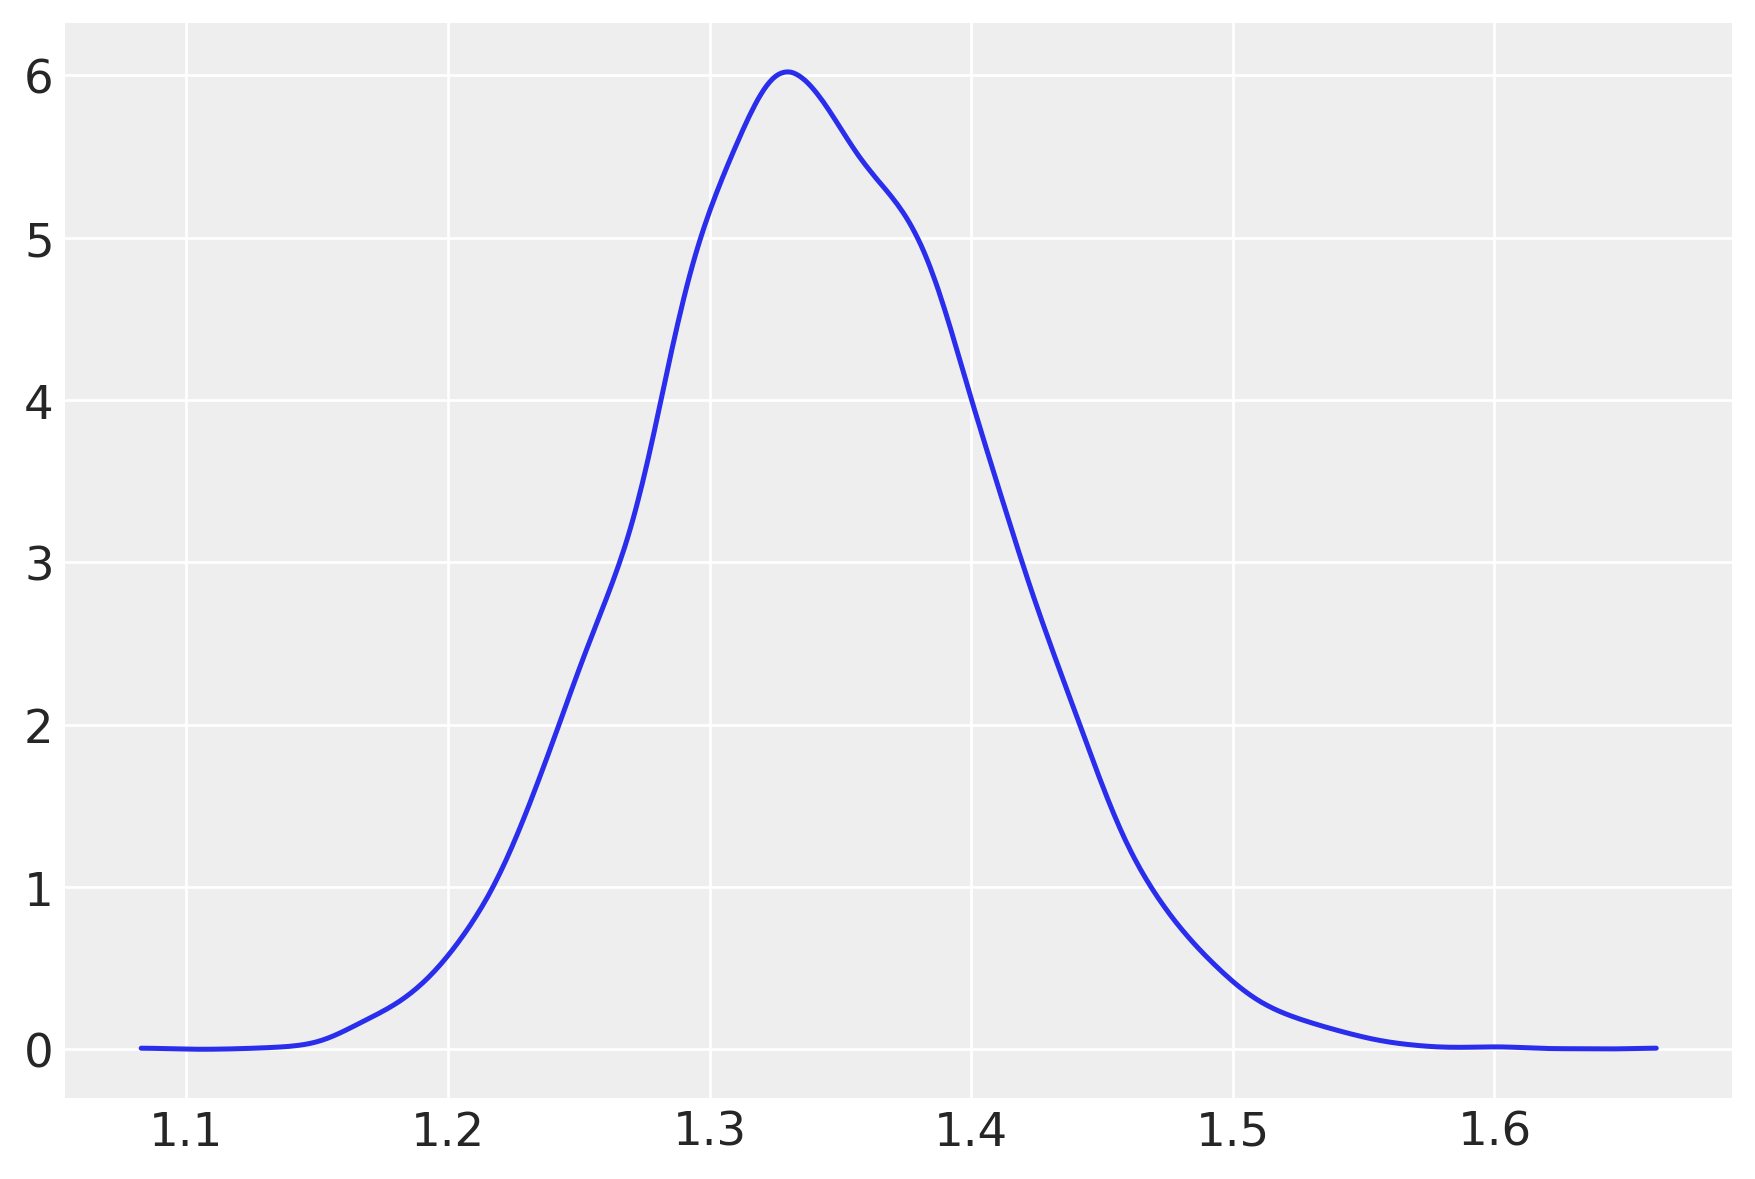

In [27]:
pos = np.random.uniform(1, 1.05, size=(12, 10000)).prod(0)
az.plot_kde(pos)
plt.show();

#### **Code 4.4**

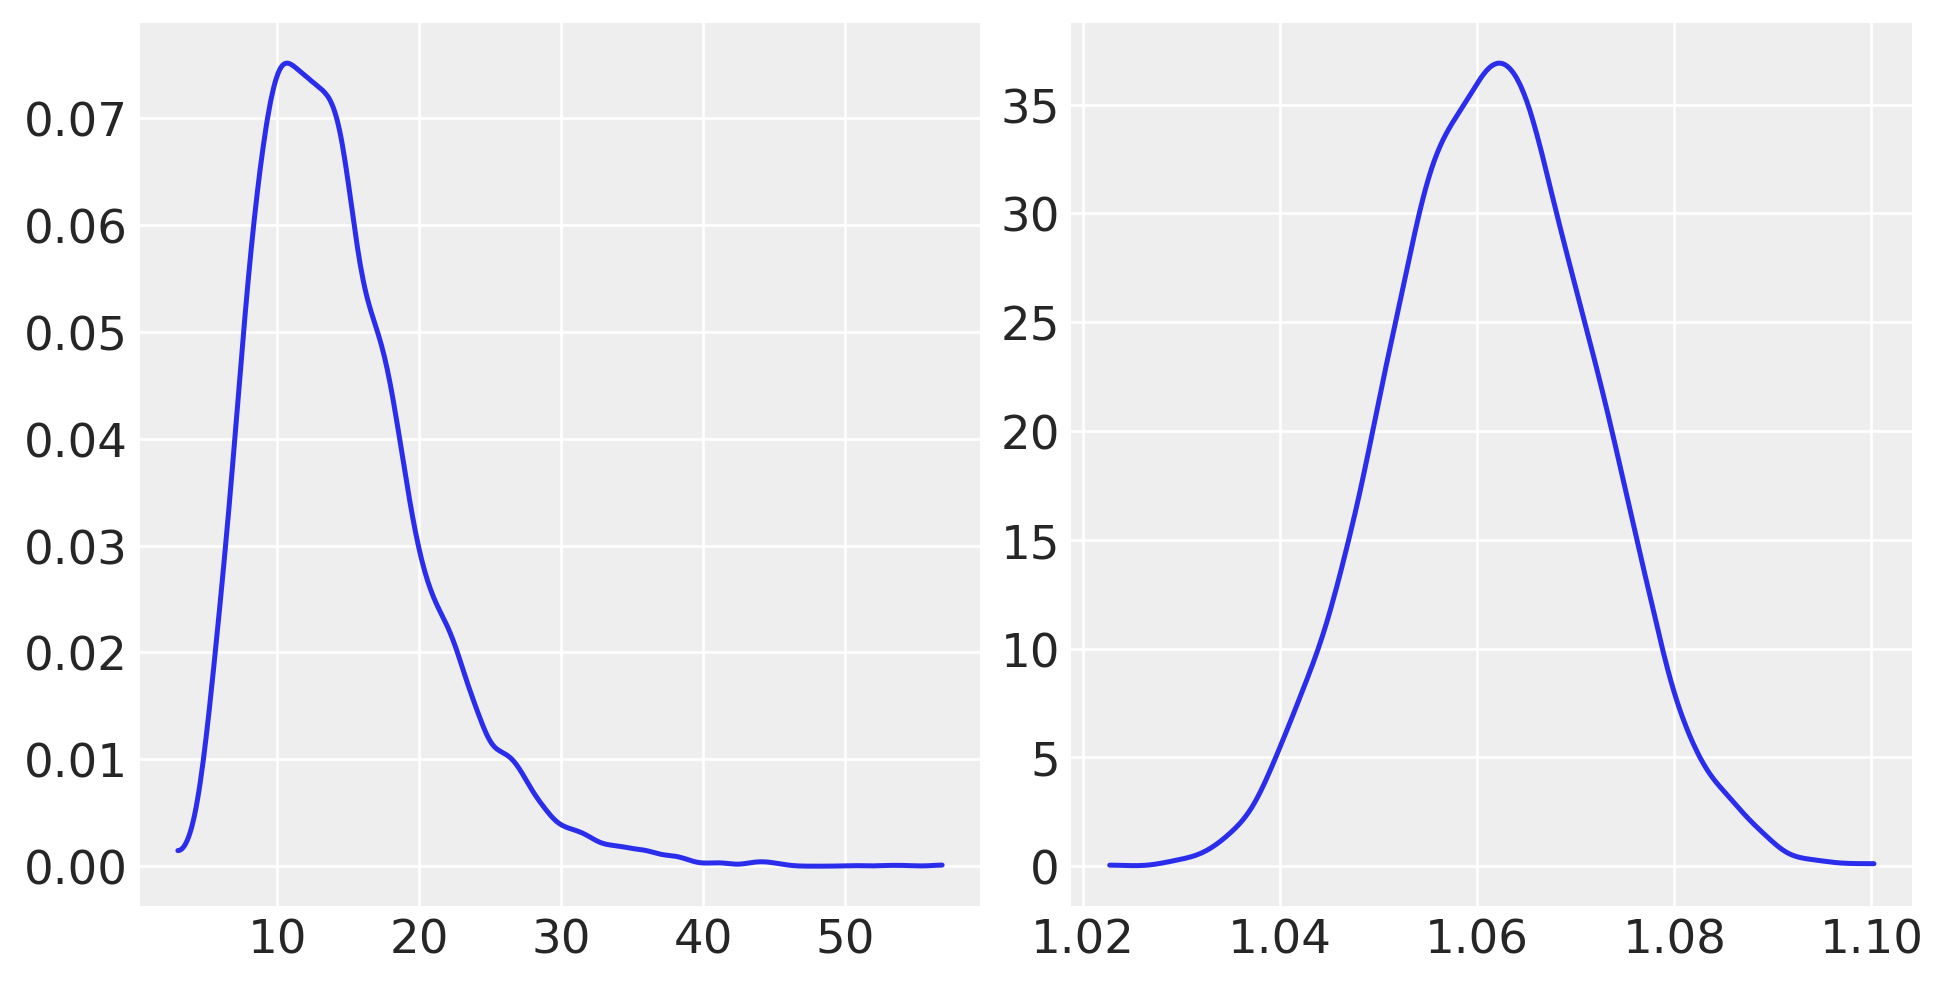

In [28]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

#### **Code 4.5**

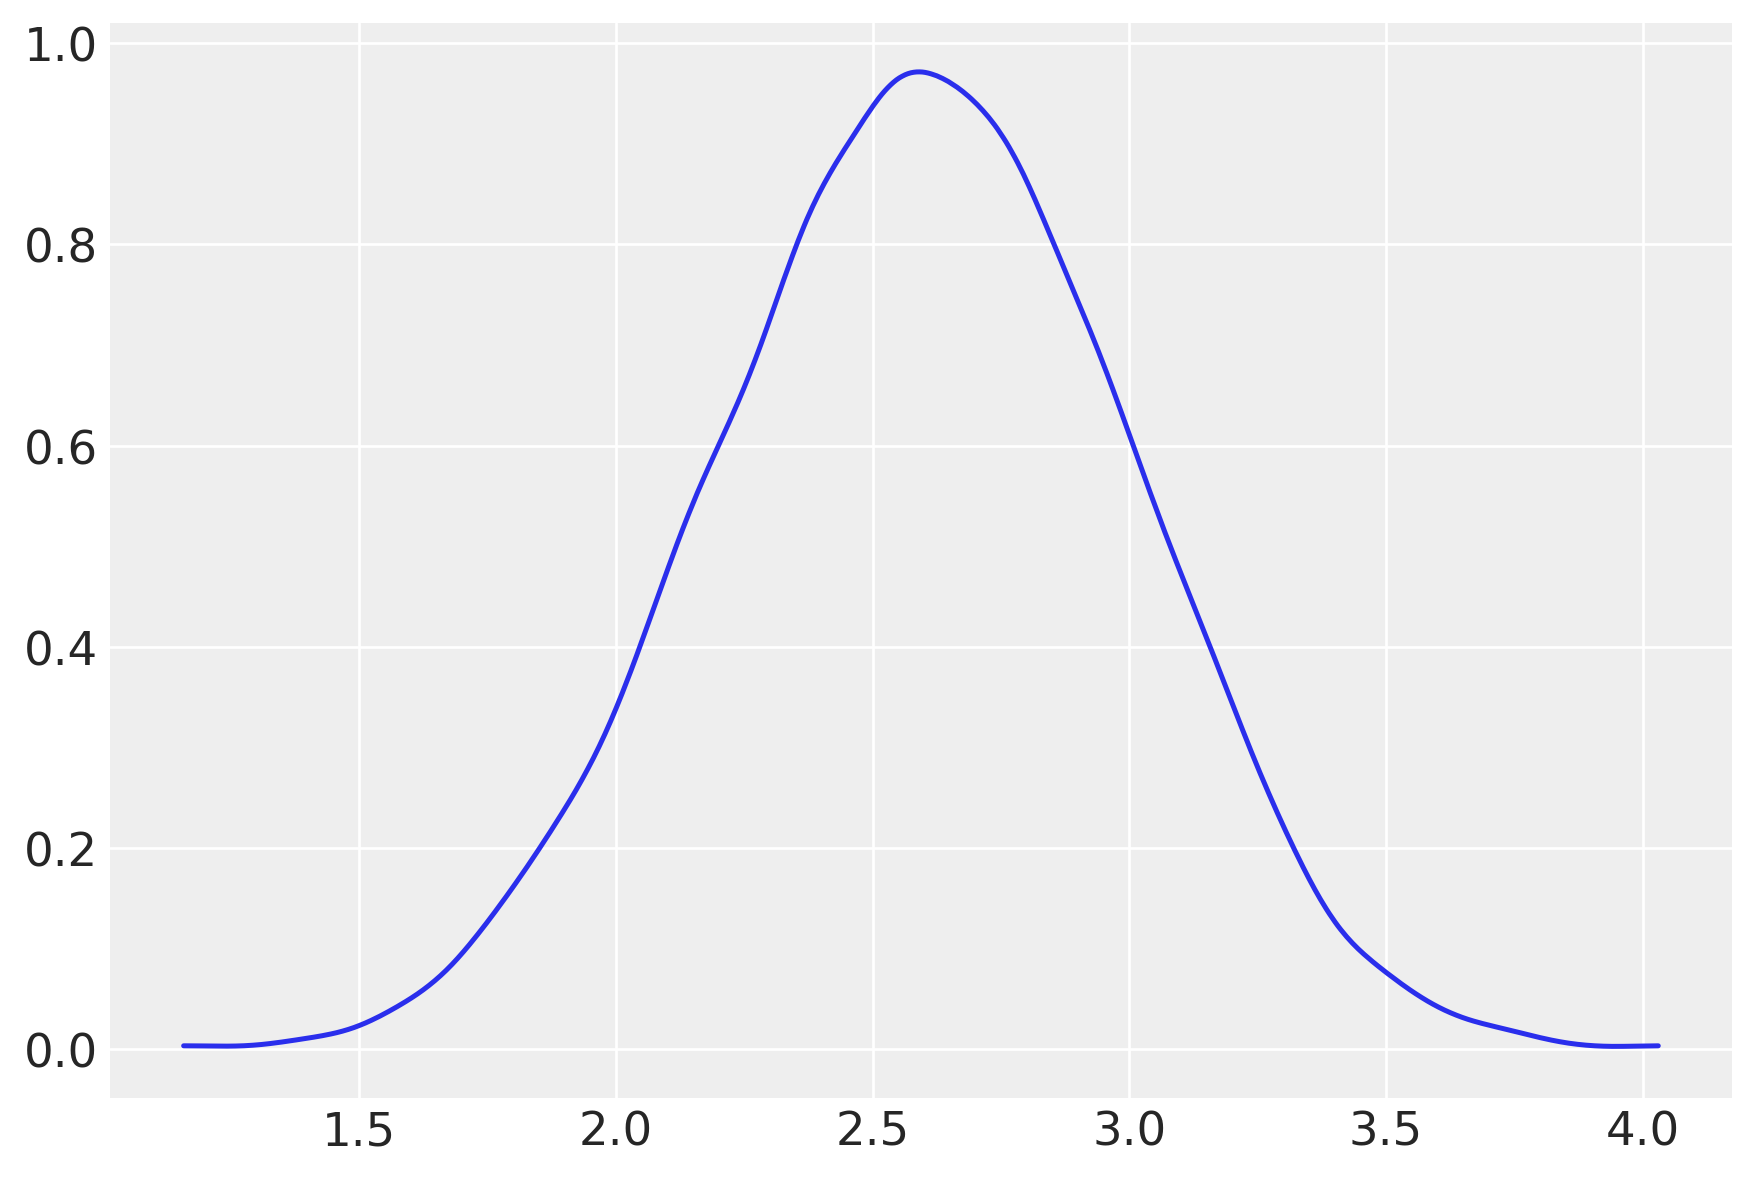

In [29]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

#### **Code 4.6**

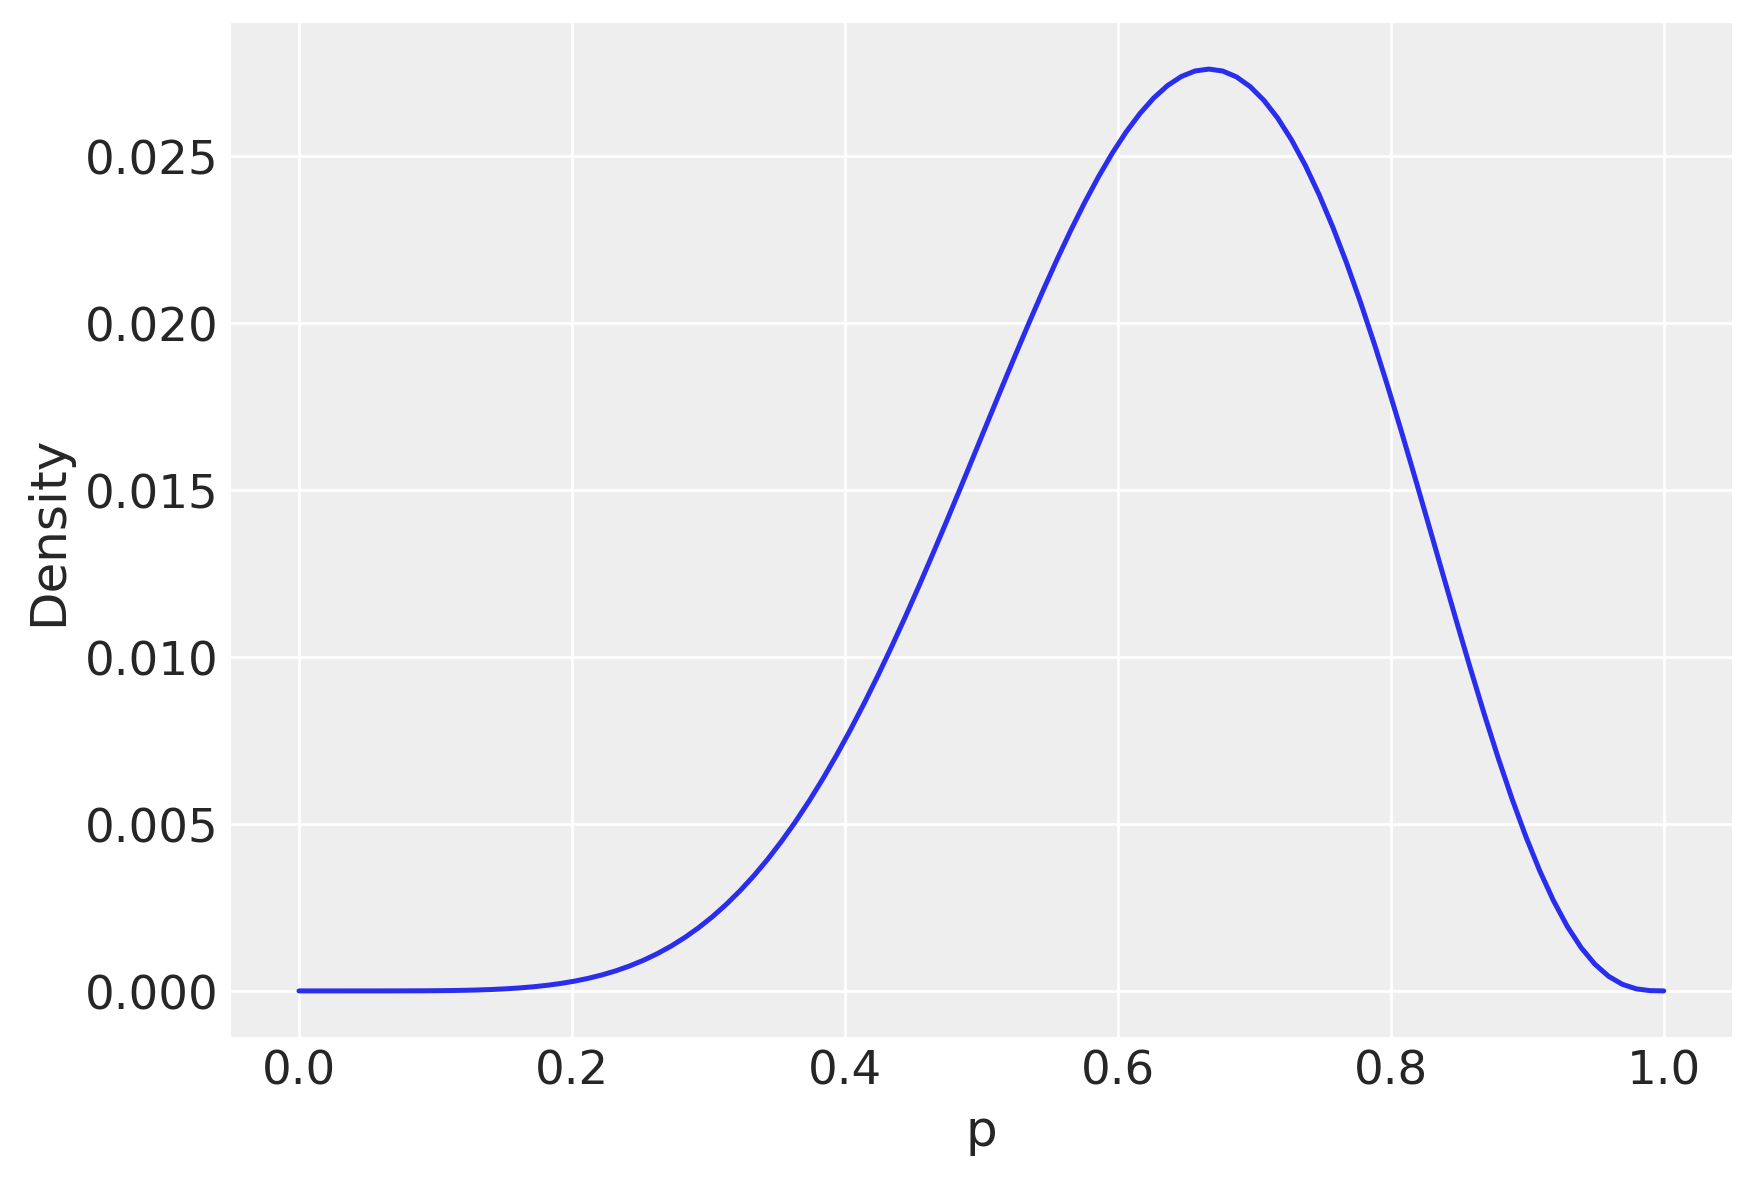

In [31]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
prior = stats.uniform.pdf(p_grid, 0, 1)
likelihood = stats.binom.pmf(k=w, n=n, p=p_grid)
posterior = likelihood * prior
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density");

#### **Code 4.7 and 4.8**

In [44]:
d = pd.read_csv(f"{parent_dir}/data/howell1.csv", sep=";", header=0)
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

#### **Code 4.9**

In [45]:
az.summary(d.to_dict(orient="list"), kind="stats")

mean      sd  hdi_5.5%  hdi_94.5%
height  138.264  27.602    90.805    170.180
weight   35.611  14.719    11.368     55.707
age      29.344  20.747     0.000     57.000
male      0.472   0.500     0.000      1.000

#### **Code 4.10 & Code 4.11**

In [46]:
d.height
d2 = d[d.age >= 18]

#### **Code 4.12**

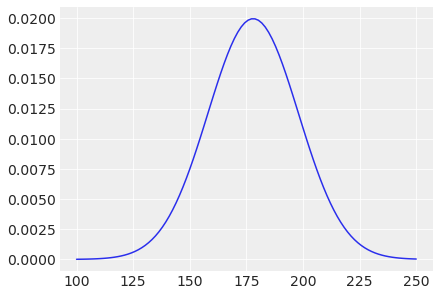

In [47]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### **Code 4.13**

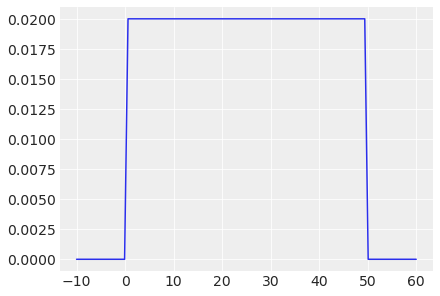

In [48]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### **Code 4.14**

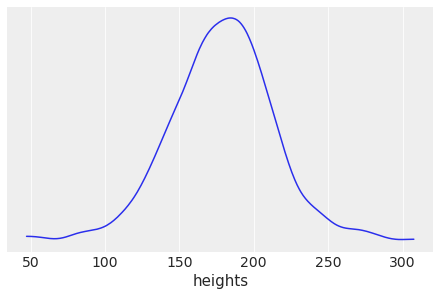

In [49]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

#### **Code 4.15**

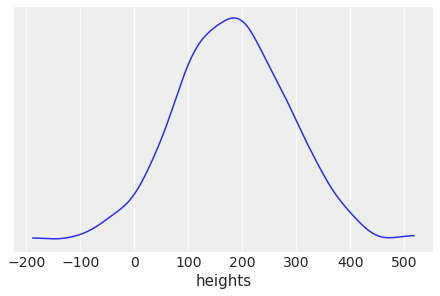

In [50]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

#### **Code 4.16**

In [51]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

#### **Code 4.17**

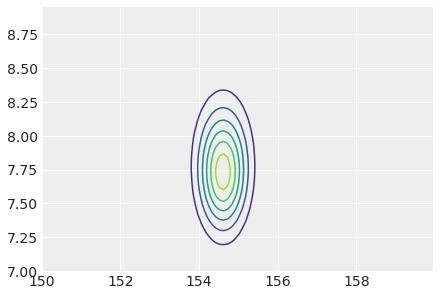

In [52]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

#### **Code 4.18**

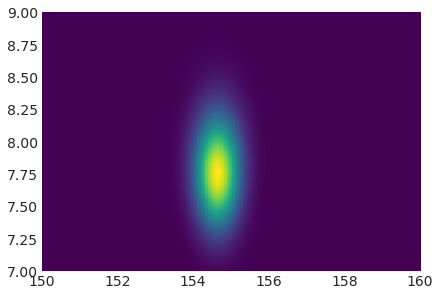

In [53]:
_, ax = plt.subplots()
ax.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto")
ax.grid(False)

#### **Code 4.19 and 4.20**

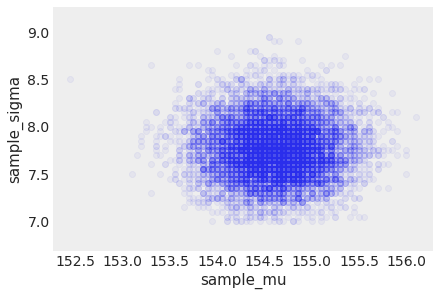

In [54]:
sample_rows = np.random.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

#### **Code 4.21**

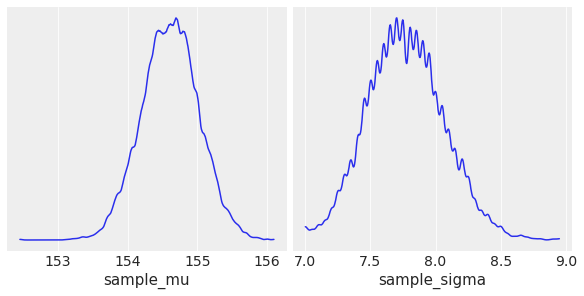

In [55]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([]);

#### **Code 4.22**

In [56]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.9, 155.2]), array([7.3, 8.2]))

#### **Code 4.23 and  4.24**

In [57]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

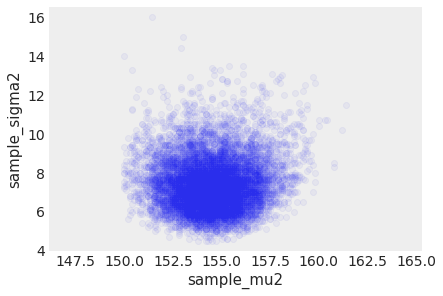

In [58]:
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False);

#### **Code 4.25**

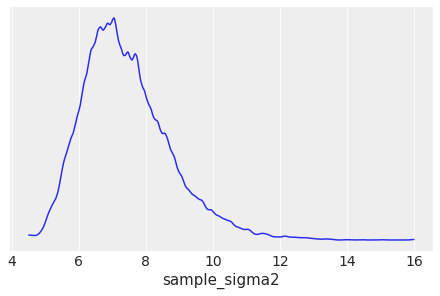

In [59]:
az.plot_kde(sample_sigma2)
plt.xlabel("sample_sigma2")
plt.yticks([]);

#### **Code 4.26**

We are repeating code 4.7, 4.8 and 4.10

In [60]:
d = pd.read_csv(f"{parent_dir}/data/howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]

#### **Code 4.27**

In [61]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

#### **Code 4.28**

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC3 [here](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html)

In [62]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


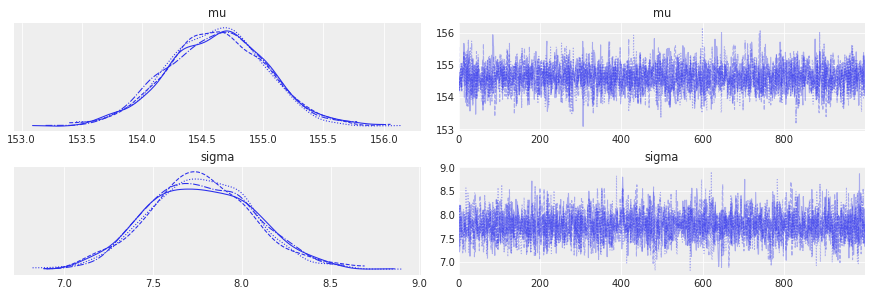

In [64]:
az.plot_trace(trace_4_1);
# this function lets you check the samples values

#### **Code 4.29**

In [65]:
az.summary(trace_4_1, round_to=2, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.


mean    sd  hdi_5.5%  hdi_94.5%
mu     154.62  0.41    153.97     155.26
sigma    7.77  0.30      7.29       8.25

#### **Code 4.30**

In [68]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)
az.summary(trace_4_1, round_to=2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.43    153.93     155.29
sigma    7.77  0.29      7.28       8.19

#### **Code 4.31**

In [66]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sd=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


mean    sd  hdi_5.5%  hdi_94.5%
mu     177.87  0.10    177.70     178.03
sigma   24.60  0.96     23.11      26.16

#### **Code 4.32**

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [74]:
trace_df.head()

mu     sigma
0  155.396593  8.268170
1  155.241300  7.758748
2  154.012173  7.843980
3  155.059502  7.708311
4  154.569972  7.301157

In [69]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

mu     sigma
mu     0.181038  0.002464
sigma  0.002464  0.081582

#### **Code 4.33**

In [70]:
np.diag(trace_df.cov())

array([0.1810382 , 0.08158163])

In [71]:
trace_df.corr()

mu     sigma
mu     1.000000  0.020272
sigma  0.020272  1.000000

#### **Code 4.34**

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

Or directly from the trace (we are getting the first ten samples of _sigma_)

In [75]:
trace_4_1["sigma"][:10]

array([8.26817049, 7.75874794, 7.84398032, 7.70831066, 7.30115745,
       7.20609555, 7.55211801, 7.55211801, 7.95046892, 8.35012196])

#### **Code 4.35**

In our case, this is the same we did in the code 4.27

In [76]:
az.summary(trace_4_1, round_to=2, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.


mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.43    153.93     155.29
sigma    7.77  0.29      7.28       8.19

#### **Code 4.36**

In [78]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.65550999,   7.98651331],
       [154.60762887,   7.65440085],
       [154.45696406,   7.1174024 ],
       [155.23355056,   7.99934434],
       [154.98043746,   7.41560528],
       [154.13039447,   7.73943247],
       [155.29035198,   7.84836907],
       [154.72371749,   7.91060967],
       [154.14488879,   7.92354573],
       [154.7681255 ,   7.74362688]])

#### **Code 4.37**

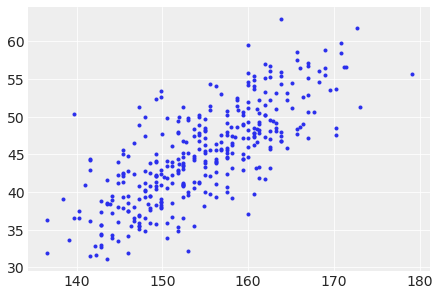

In [79]:
plt.plot(d2.height, d2.weight, ".");

#### **Code 4.38**

In [87]:
np.random.seed(2971)
N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

#### **Code 4.39 and 4.40**

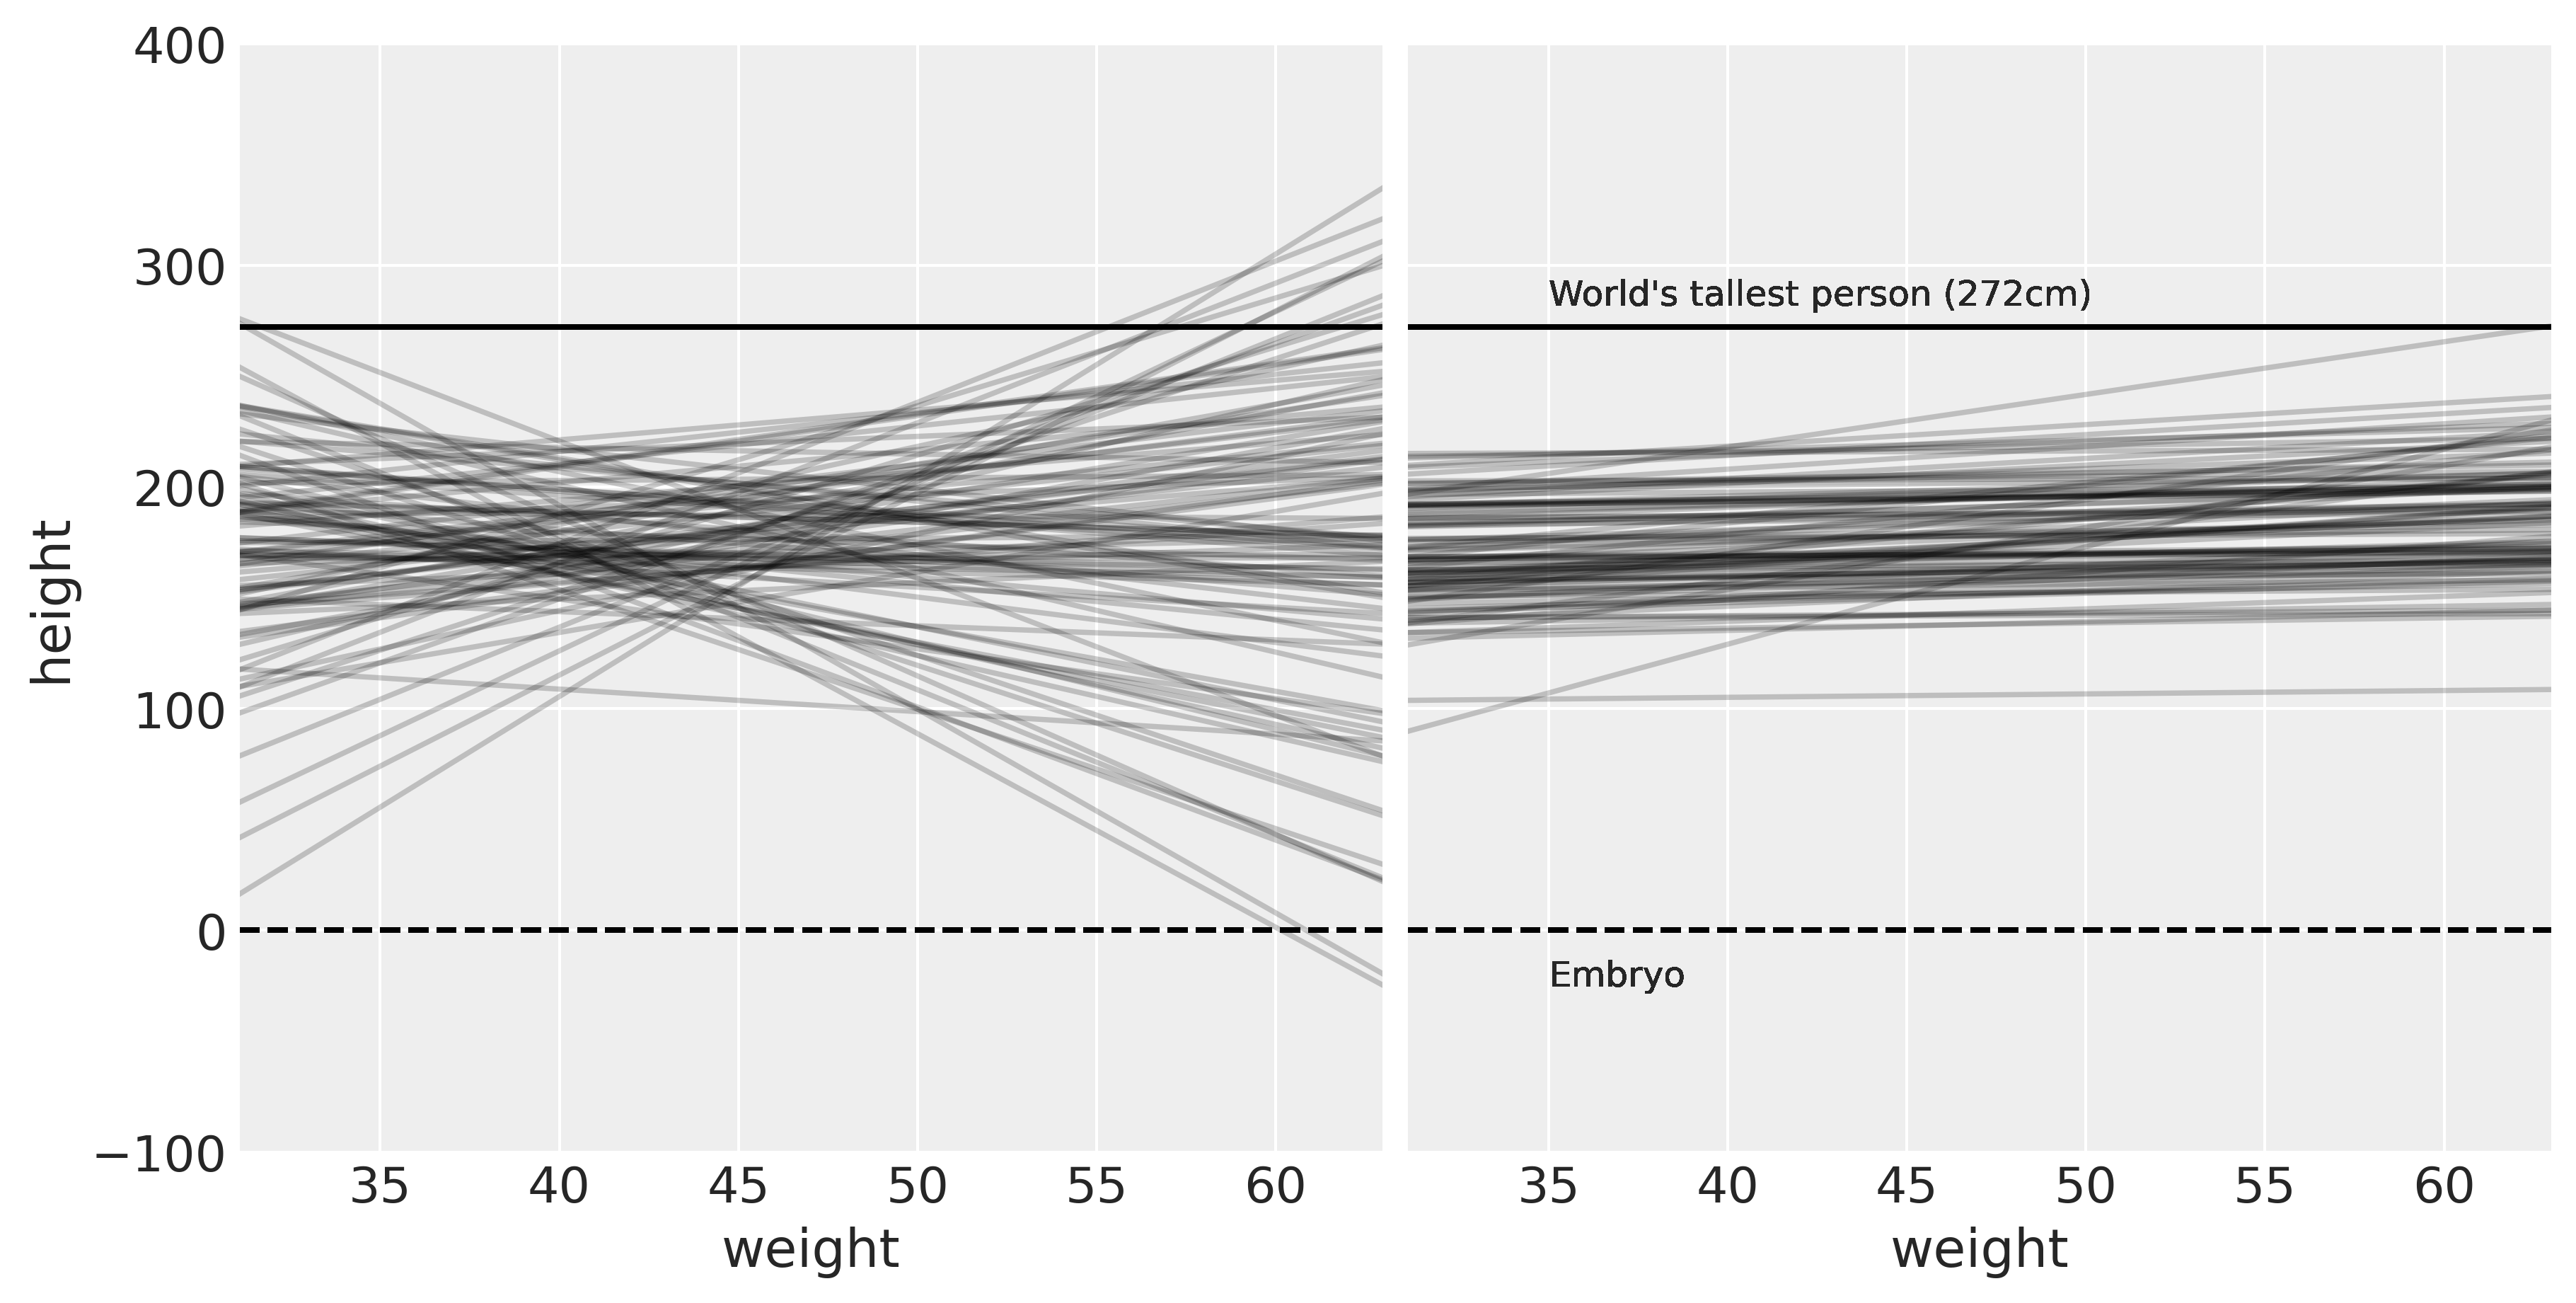

In [88]:
_, ax = plt.subplots(1, 2, sharey=True, figsize = (10, 5), dpi = 360)
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), N)
for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo");

#### **Code 4.42**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


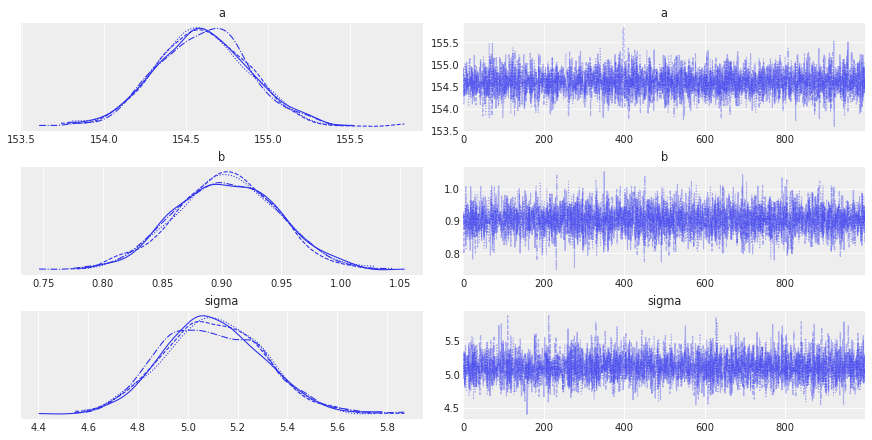

In [90]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)
az.plot_trace(trace_4_3);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


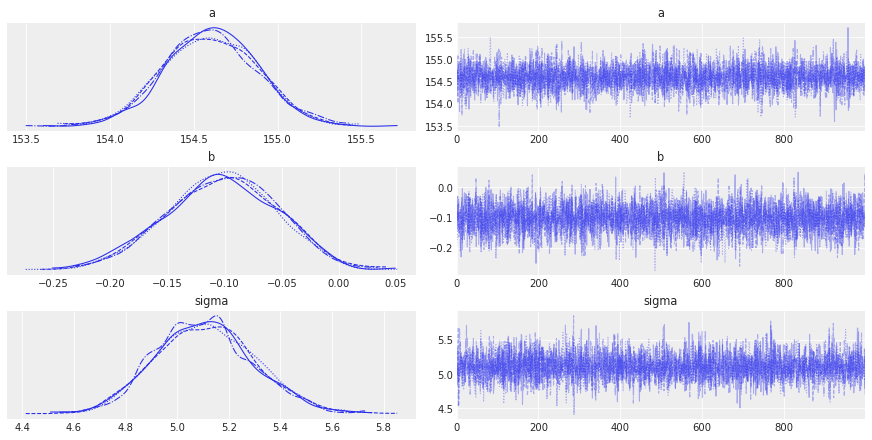

In [91]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Normal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b) * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_3b = pm.sample(1000, tune=1000)
az.plot_trace(trace_4_3b);

#### **Code 4.44**

In [92]:
az.summary(trace_4_3, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.


mean     sd  hdi_5.5%  hdi_94.5%
a      154.602  0.280   154.160    155.047
b        0.904  0.043     0.835      0.971
sigma    5.105  0.201     4.774      5.405

#### **Code 4.45**

In [93]:
trace_4_3_df = pm.trace_to_dataframe(trace_4_3)
trace_4_3_df.cov().round(3)

a      b  sigma
a      0.078 -0.000   0.00
b     -0.000  0.002   0.00
sigma  0.000  0.000   0.04

#### **Code 4.46**

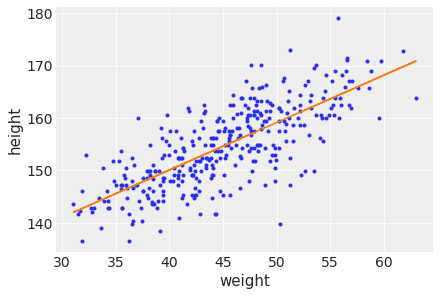

In [94]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(d2.weight, trace_4_3["a"].mean() + trace_4_3["b"].mean() * (d2.weight - xbar))
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### **Code 4.47**

In [49]:
trace_4_3_df.head(5)

a         b     sigma
0  154.563428  0.920924  5.313333
1  154.572958  0.810634  5.120046
2  154.661075  0.818422  5.022869
3  154.677476  0.980186  5.164795
4  154.530519  0.840830  4.990364

#### **Code 4.48**

In [102]:
N = [10, 50, 150, 352][0]
dN = d2[:N]
with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sd=100)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b * (dN.weight - dN.weight.mean()))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=dN.height)
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9021698452817845, but should be close to 0.8. Try to increase the number of tuning steps.


#### **Code 4.49**

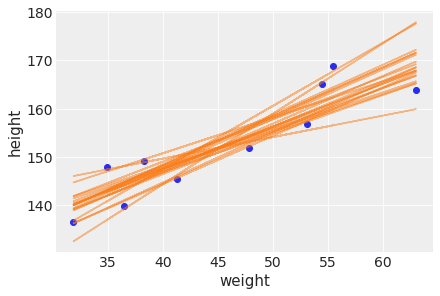

In [103]:
plt.plot(dN.weight, dN.height, "C0o")
idxs = np.random.randint(len(trace_N), size=20)
for idx in idxs:
    plt.plot(
        dN.weight,
        trace_N["a"][idx] + trace_N["b"][idx] * (dN.weight - dN.weight.mean()),
        "C1-",
        alpha=0.5,
    )
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Alternative we can directly use the deterministic `mu` variable

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


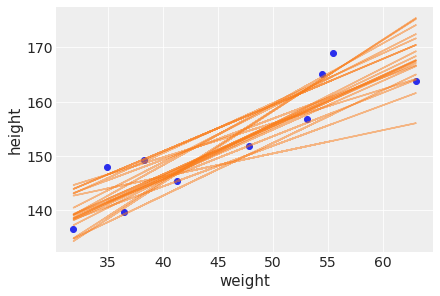

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


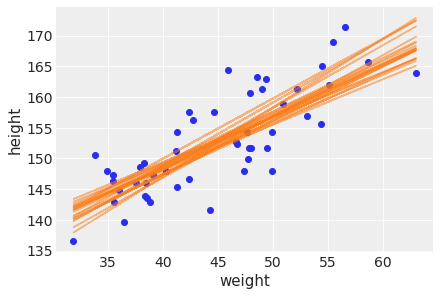

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


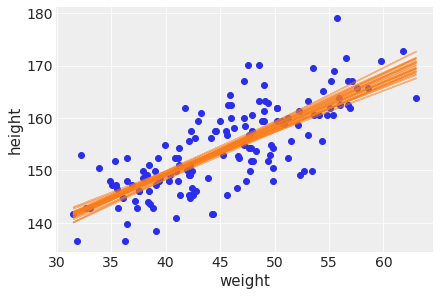

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


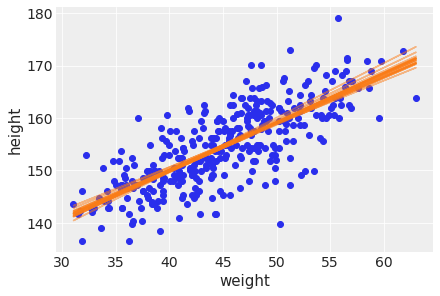

In [106]:
N = [10, 50, 150, 352]
for n in N:
    dN = d2[:n]
    with pm.Model() as m_N:
        a = pm.Normal("a", mu=178, sd=100)
        b = pm.Lognormal("b", mu=0, sd=1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = pm.Deterministic("mu", a + b * (dN.weight - dN.weight.mean()))
        height = pm.Normal("height", mu=mu, sd=sigma, observed=dN.height)
        trace_N = pm.sample(1000, tune=1000)

    plt.plot(dN.weight, dN.height, "C0o")
    for idx in idxs:
        plt.plot(d2.weight[:n], trace_N["mu"][idx], "C1-", alpha=0.5)
    plt.xlabel(d2.columns[1])
    plt.ylabel(d2.columns[0])
    plt.show();

#### **Code 4.50 and 4.51**

In [108]:
mu_at_50 = trace_4_3["a"] + trace_4_3["b"] * (50 - d2.weight.mean())

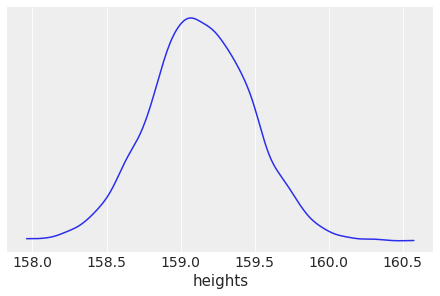

In [109]:
az.plot_kde(mu_at_50)
plt.xlabel("heights")
plt.yticks([]);

#### **Code 4.52, 4.53 and 4.54**

We are doing _manually_, in the book is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [110]:
az.hdi(mu_at_50)

array([158.56792507, 159.66998861])

In [111]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_4_3_thinned = trace_4_3[::10]
mu_pred = np.zeros((len(weight_seq), len(trace_4_3_thinned) * trace_4_3.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

#### **Code 4.55**

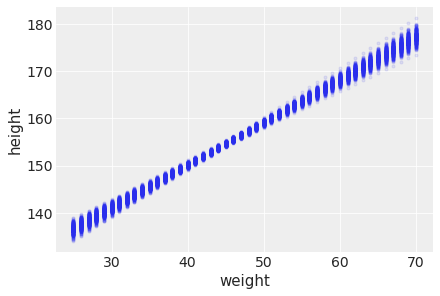

In [112]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

#### **Code 4.56**

In [113]:
mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)

#### **Code 4.57**

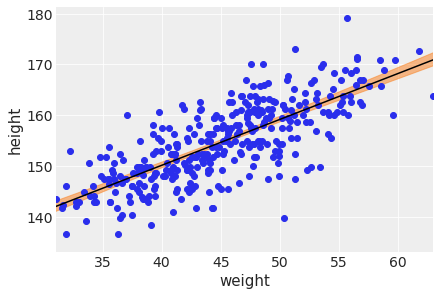

In [114]:
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### **Code 4.59**

Now we are going to use ```sample_posterior_predictive()``` from PyCM3. This function gives us posterior predictive samples, that is for each value of the input variable we get a sample (from the posterior) of the output variable. Thus in the following example the shape of `height_pred['height'].shape is (200, 352)`

In [115]:
height_pred = pm.sample_posterior_predictive(trace_4_3, 200, m4_3)

#### **Code 4.60**

In [118]:
height_pred_hdi = az.hdi(height_pred["height"])

#### **Code 4.61**

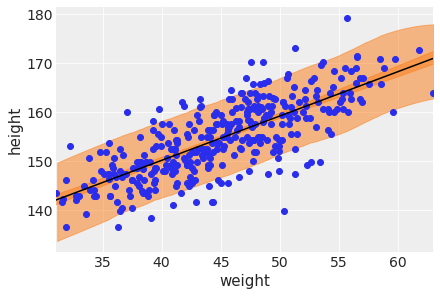

In [119]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred["height"], ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### **Code 4.62**

Change the number of samples used in 4.59 (200) to other values.

#### **Code 4.63**

Now we are going to generate heights from the posterior *manually*. Instead of restricting ourselves to the input values, we are going to pass an array of equally spaced weights values, called `weight_seg`.

In [120]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(trace_4_3))
    mu_pr = trace_4_3["a"][i] + trace_4_3["b"][i] * (weight_seq - d2.weight.mean())
    sigma_pred = trace_4_3["sigma"][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

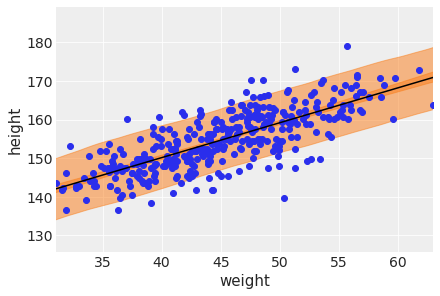

In [123]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### **Code 4.64 and 4.65**

In [124]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std ** 2

with pm.Model() as m_4_5:
    a = pm.Normal("a", mu=178, sd=100)
    b1 = pm.Lognormal("b1", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * d.weight_std + b2 * d.weight_std2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


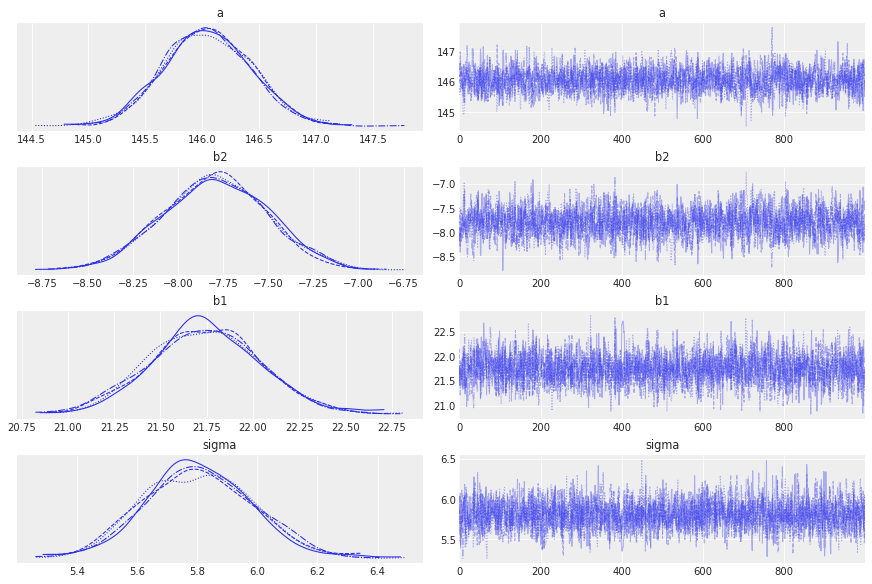

In [125]:
varnames = ["~mu"]
az.plot_trace(trace_4_5, varnames);

#### **Code 4.66**

In [127]:
az.summary(trace_4_5, varnames, kind="stats", round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


mean    sd  hdi_5.5%  hdi_94.5%
a      146.05  0.38    145.46     146.67
b2      -7.79  0.29     -8.28      -7.36
b1      21.74  0.30     21.27      22.21
sigma    5.81  0.18      5.51       6.07

#### **Code 4.67**

In [128]:
mu_pred = trace_4_5["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_5, 200, m_4_5)

#### **Code 4.68**

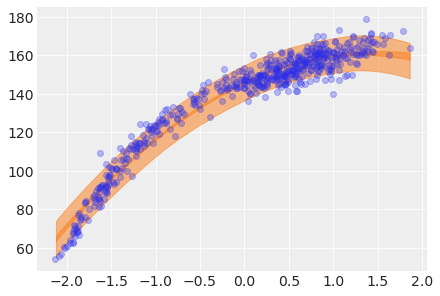

In [130]:
ax = az.plot_hdi(d.weight_std, mu_pred)
az.plot_hdi(d.weight_std, height_pred["height"], ax=ax)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3);

#### **Code 4.69**

We will stack the weights to get a 2D array, this simplifies writing a model. Now we can compute the dot product between beta and the 2D-array

In [135]:
weight_m = np.vstack((d.weight_std, d.weight_std ** 2, d.weight_std ** 3))
print(np.shape(weight_m))

(3, 544)


In [136]:
with pm.Model() as m_4_6:
    a = pm.Normal("a", mu=178, sd=100)
    b = pm.Normal("b", mu=0, sd=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.881179262708478, but should be close to 0.8. Try to increase the number of tuning steps.


#### **Code 4.70 and 4.71**

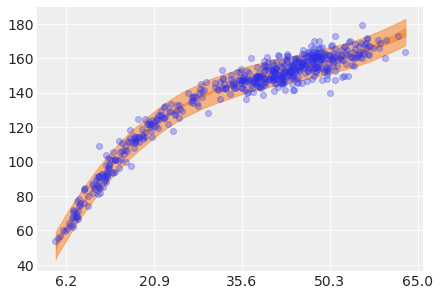

In [137]:
mu_pred = trace_4_6["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_6, 200, m_4_6)

ax = az.plot_hdi(d.weight_std, mu_pred)
az.plot_hdi(d.weight_std, height_pred["height"], ax=ax)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

#### **Code 4.72**

In [140]:
d = pd.read_csv(f"{parent_dir}/data/cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

mean       sd  hdi_5.5%  hdi_94.5%
year        1533.395  291.123   1123.00    1978.00
doy          104.921    6.258     95.00     114.00
temp           6.100    0.683      5.00       7.13
temp_upper     6.938    0.812      5.57       7.98
temp_lower     5.264    0.762      4.12       6.40

#### **Code 4.73**

In [141]:
d2 = d.dropna(subset=["doy"])
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

#### **Code 4.74**

Here we will use patsy as a simple way of building the b-spline matrix. For more detail please read https://patsy.readthedocs.io/en/latest/spline-regression.html

In [142]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

#### **Code 4.75**

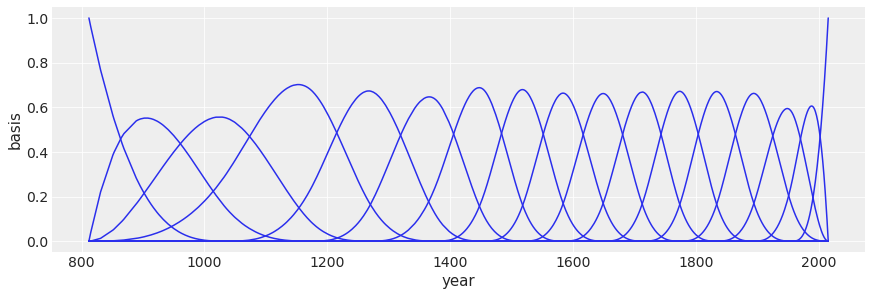

In [143]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(d2.year, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

#### **Code 4.76**

Note: if the mode gets stall instead of sampling try replacing `mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))` with `mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))`

In [144]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m4_7 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


#### **Code 4.77**

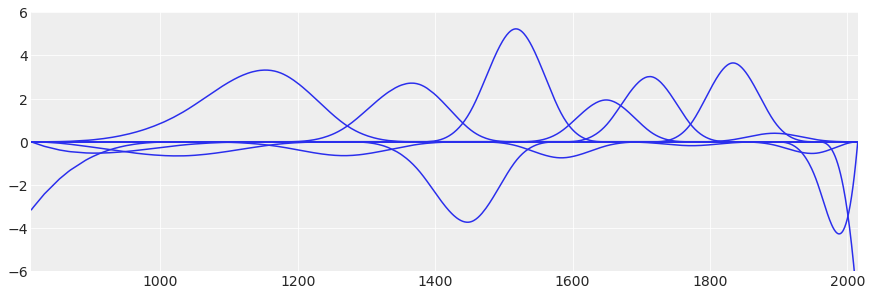

In [145]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
wp = trace_m4_7[w].mean(0)
for i in range(17):
    ax.plot(d2.year, (wp[i] * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

#### **Code 4.78**

Text(0, 0.5, 'days in year')

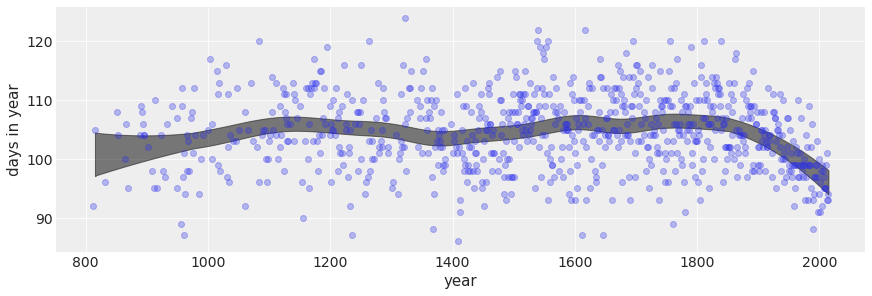

In [146]:
ax = az.plot_hdi(d2.year, trace_m4_7["mu"], color="k")
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

In [147]:
%watermark -n -u -v -iv -w

Last updated: Thu Apr 14 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.1.1

numpy     : 1.21.2
arviz     : 0.11.4
pandas    : 1.4.1
pymc3     : 3.11.5
matplotlib: 3.5.1
seaborn   : 0.11.2
sys       : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
scipy     : 1.7.3

Watermark: 2.3.0

